In [79]:
# Math and Dataframes
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.ticker import PercentFormatter

# Machine Learning 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
# import verstack
# from verstack.stratified_continuous_split import scsplit

# Others
from datetime import datetime
import os
from pathlib import Path
import csv
import pickle

In [80]:
from draft import Regression_Hertz, Hertz_Dataset, error_fn, plot_error_hist, plot_bad_curves, plot_pred_real_curves

In [81]:
def plot_loss_curve(epochs, mse_training, mse_validation, loss: bool):
  plt.figure()
  plt.xlabel("Epoch")
  if loss:
    plt.ylabel("Loss")
    plt.plot(epochs[0:], mse_training[0:], label="Training Loss")
    plt.plot(epochs[0:], mse_validation[0:], label="Validation Loss")
  else:
    plt.ylabel("Error (\%)")
    plt.plot(epochs[0:], mse_training[0:], label="Training Error")
    plt.plot(epochs[0:], mse_validation[0:], label="Validation Error")    
  plt.legend()  
  # We're not going to plot the first epoch (>>greater loss)
  '''merged_mse_lists = mse_training[1:] + mse_validation[1:]
  highest_loss = max(merged_mse_lists)
  lowest_loss = min(merged_mse_lists)
  delta = highest_loss - lowest_loss
  top_of_y_axis = highest_loss + (delta * 0.2)
  bottom_of_y_axis = lowest_loss - (delta * 0.2)   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])'''
  if loss:
    plt.ylim([1e-4, 0.1])
    plt.savefig('loss_plot.pdf') 
  else:
    plt.ylim([0, 10])
    plt.savefig('error_plot.pdf')
  plt.show()

def plot_error_hist3(error_list, test: bool, **kwargs):
  '''**kwargs: percentage of curves with errors under x%. 
              The values must be provided for errors in ascending order (error1 = y, error2_5 = z)'''
  fig, ax = plt.subplots()
  plt.figure()
  x_values = [1, 2.5]
  error_values = list(kwargs.values())
  ax.hist(error_list, bins=20, density=True, ec='black', range=(0,6)) # to remove outliers, set parameter 'range='
  ax.set_xlabel("Error (\%)", fontsize=14)
  ax.set_ylabel("Density", fontsize=14)
  #plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) # set y axis as %
  ax.yaxis.set_major_formatter(PercentFormatter(1))
  if test:
    ax.axvline(x_values[0], color='red', linestyle='--', label=f'{error_values[0]*100: .1f}\% of curves with $\epsilon<1\%$')
    ax.axvline(x_values[1], color='green', linestyle='--', label=f'{error_values[1]*100: .1f}\% of curves with $\epsilon<2.5\%$')
    ax.legend(loc='center', ncol=2, bbox_to_anchor=(0.5, 1.05), fontsize=13)
    ax.text(0.76, 0.95, f'Num. of tested curves: {len(error_list)}', transform=ax.transAxes, fontsize=13, ha='center', 
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
    # ax.set_title("Test error")
    fig.savefig('error_hist_test2.pdf')
  else:
    fig.savefig('error_hist_valid_2.pdf') 
  plt.show()

In [82]:
timestamp = '20230618_025734'
model_dir = 'model_{}'.format(timestamp)
# model_dir = '000_basemodel1'
parent_dir = 'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese'
dir = 'Hertz_models'
path = os.path.join(parent_dir, dir, model_dir)
# path = os.path.join(initial_wd, dir, model_dir)
os.chdir(path)

print(os.getcwd())

c:\Users\luisr\OneDrive\Ambiente de Trabalho\Tese\Hertz_models\model_20230618_025734


In [83]:
with open('model_params.csv', 'r') as file:
    reader = csv.DictReader(file)
    data = list(reader)
    model_params = data[0]

model_params.keys()

dict_keys(['Epochs', 'Learning Rate', 'Batch Size', 'Number of Hidden layers', 'Type of layers', 'Activation function', 'Architecture', 'Hidden Units 1', 'Hidden Units 2', 'Hidden Units 3', 'Input shape', 'Loss function', 'Optimizer', 'nu', 'radius', 'xmax', 'Training Time', 'Model Path'])

In [84]:
# Load test data
x_test_t = torch.load('x_test_t.pt')
y_test_t = torch.load('y_test_t.pt')

nu = float(model_params['nu'])
r = float(model_params['radius'])

# Open pkl files (requires change to directory Train_Validation_Data)
# with open('nested_array.pkl', 'rb') as f:
    # loaded_nested_array = pickle.load(f)

test_data = Hertz_Dataset(x_test_t, y_test_t)

BATCH_SIZE = int(model_params['Batch Size'])
# test_loader=DataLoader(test_data,batch_size=int(test_ratio*size+1),shuffle=False)
test_loader=DataLoader(test_data,batch_size=BATCH_SIZE, shuffle=False)

In [85]:
# Input shape in correct format
input_raw = model_params['Input shape'].strip('][').split(', ')
input_shape = [int(i) for i in input_raw]

#Hidden units
n_hidden = int(model_params['Number of Hidden layers'])
HIDDEN_UNITS_1 = int(model_params['Hidden Units 1'])
HIDDEN_UNITS_2 = int(model_params['Hidden Units 2'])
# Assign hidden units according to the number of hidden layers
if n_hidden >= 2:
    try:
        HIDDEN_UNITS_3 = int(model_params['Hidden Units 3'])
    except:
        HIDDEN_UNITS_3 = None
        pass
if n_hidden > 3:
    HIDDEN_UNITS_4 = int(model_params['Hidden Units 4'])
if n_hidden > 4:
    HIDDEN_UNITS_5 = int(model_params['Hidden Units 5'])
if n_hidden > 5:
    HIDDEN_UNITS_6 = int(model_params['Hidden Units 6'])


model_path = model_params['Model Path']
print(model_path)

loss_fn = eval('nn.' + model_params['Loss function']) # [:-2] to remove the parenthesis
print(loss_fn)

model_state_dict_20230618_025734_6.pt
HuberLoss()


In [86]:
torch.manual_seed(42)

loaded_model = Regression_Hertz(input_shape=input_shape,
                                HIDDEN_UNITS_1=HIDDEN_UNITS_1,
                                HIDDEN_UNITS_2=HIDDEN_UNITS_2,
                                HIDDEN_UNITS_3=HIDDEN_UNITS_3)

# Load in the saved state_dict
loaded_model.load_state_dict(torch.load(f=model_path))

# See model architecture and state_dict (weights and biases)
loaded_model, loss_fn
#loaded_model.state_dict()

(Regression_Hertz(
   (layers): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=100, out_features=16, bias=True)
     (2): LeakyReLU(negative_slope=0.01)
     (3): Linear(in_features=16, out_features=16, bias=True)
     (4): LeakyReLU(negative_slope=0.01)
     (5): Linear(in_features=16, out_features=16, bias=True)
     (6): LeakyReLU(negative_slope=0.01)
     (7): Linear(in_features=16, out_features=1, bias=True)
   )
 ),
 HuberLoss())

In [87]:
def eval_model(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               error_fn):
    model.eval()
    loss, error = 0, 0
    error_list, fts_list, labels_list, predicts_list = [], [], [], []
    with torch.inference_mode():
        for i, testdata in enumerate(data_loader):
            test_fts, test_labels = testdata
            fts_list.append(test_fts)
            labels_list.append(test_labels)
            y_pred = model(test_fts)
            predicts_list.append(y_pred)
            loss += loss_fn(y_pred, test_labels) 
            error_aux, error_list_aux = error_fn(y_pred, test_labels)
            error += error_aux
            error_list += error_list_aux
        loss /= len(data_loader)
        error /= len(data_loader)
    error1 = len([i for i in error_list if i <= 1])/len(error_list)
    error2_5 = len([i for i in error_list if i <= 2.5])/len(error_list)
    error5 = len([i for i in error_list if i <= 5])/len(error_list)
    error10 = len([i for i in error_list if i <= 10])/len(error_list)
    
    results_dict = {"model_name": model.__class__.__name__,
                    "model_loss": loss.item(),
                    "model_error": error,
                    "under_1%_error": error1,
                    "under_2.5%_error": error2_5,
                    "under_5%_error": error5,
                    "under_10%_error": error10}
    
    with open('test_results.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = results_dict.keys())
        writer.writeheader()
        writer.writerow(results_dict)
    plot_error_hist(error_list, test=True, error1=error2_5, error2=error10)
    plot_error_hist3(error_list, test=True, error1=error1, error2=error2_5)
    plot_bad_curves(error_list, fts_list, labels_list, test=True)
    plot_pred_real_curves(error_list, fts_list, labels_list, test=True, list_predicts=predicts_list, nu=nu, r=r)
    print(results_dict)


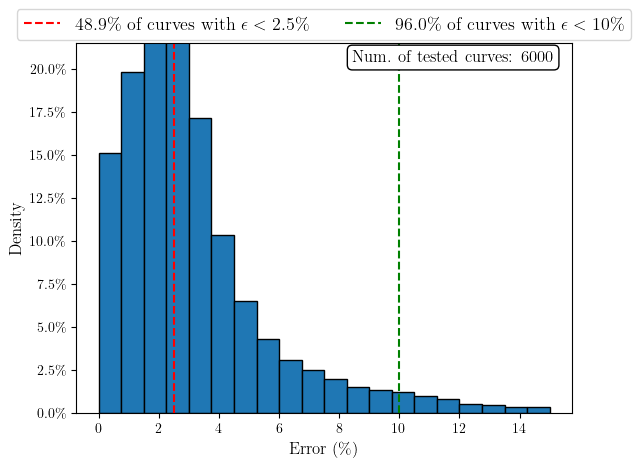

<Figure size 640x480 with 0 Axes>

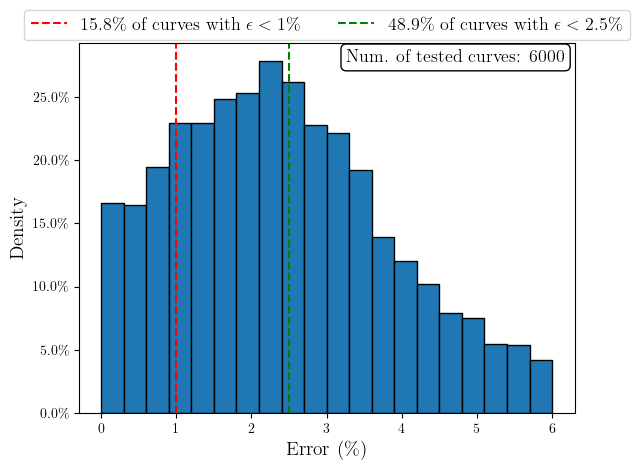

<Figure size 640x480 with 0 Axes>

{'model_name': 'Regression_Hertz', 'model_loss': 0.008189800195395947, 'model_error': 3.2627682394169746, 'under_1%_error': 0.15816666666666668, 'under_2.5%_error': 0.4891666666666667, 'under_5%_error': 0.8321666666666667, 'under_10%_error': 0.9601666666666666}


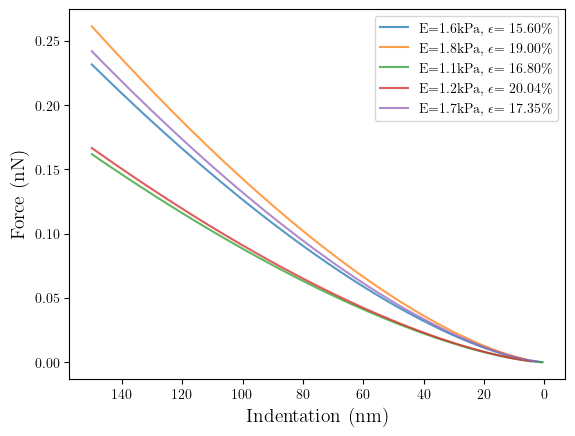

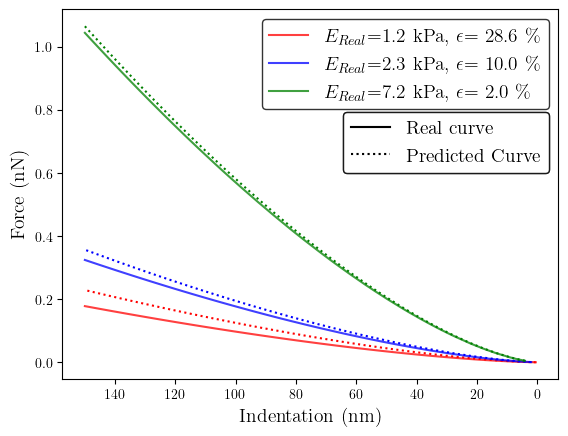

In [88]:
eval_model(loaded_model, test_loader, loss_fn, error_fn)